# CNN - Final model

Here we develop a CNN that takes as input a square patch of voxels from the PETMR scans and predicts the corresponding central voxel of the TRIO scan. Note we only use b=0 intensity values

### Upload the data required

We use both scans of subjects 1-8 from the PETMR and TRIO dataset for training.

We used the scan of subjects 9-10 also from the PETMR and TRIO dataset for testing.

## FUNCTIONS

In [40]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from IPython import display
import random

In [41]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict, input_scanner):
    
    train_val_test_inp = []
    train_val_test_out1 = []
    train_val_test_out2 = []
    test_data_inp = []
    test_data_out1 = []
    test_data_out2 = []
    
    if input_scanner == "PETMR":
        input_path = petmr_path
        output_path = trio_path
    else:
        input_path = trio_path
        output_path = petmr_path       
    
    for key, subjs in scans_dict.iteritems():
        for subj_scan in subjs:
                
            input_scan_image = nib.load(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/Brain_Matched.nii.gz")
            input_scan_data = input_scan_image.get_data()
                
            # Important : Upload the output scan that is registered to the appropriate input scan
            output_scan_image1 = nib.load(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1" + "/Brain_Matched_Scan" + str(subj_scan[1]) + ".nii.gz")
            output_scan_data1 = output_scan_image1.get_data()
            
            output_scan_image2 = nib.load(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan2" + "/Brain_Matched_Scan" + str(subj_scan[1]) + ".nii.gz")
            output_scan_data2 = output_scan_image2.get_data()
                
            input_bvals_scan, input_bvecs_scan = read_bvals_bvecs(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bval",\
                                                          str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bvec")
                
            output_bvals_scan1, output_bvecs_scan1 = read_bvals_bvecs(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bval",\
                                                          str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bvec")
            
            output_bvals_scan2, output_bvecs_scan2 = read_bvals_bvecs(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan2/NODDI.bval",\
                                                          str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan2/NODDI.bvec")
                
            #set a threshold value for b=0 values (due to TRIO dataset)
            input_gtab_scan = gradient_table(input_bvals_scan, input_bvecs_scan, b0_threshold=5)
            input_s0s_scan = input_scan_data[:, :, :, input_gtab_scan.b0s_mask]
                
            output_gtab_scan1 = gradient_table(output_bvals_scan1, output_bvecs_scan1, b0_threshold=5)
            output_s0s_scan1 = output_scan_data1[:, :, :, output_gtab_scan1.b0s_mask]
            
            output_gtab_scan2 = gradient_table(output_bvals_scan2, output_bvecs_scan2, b0_threshold=5)
            output_s0s_scan2 = output_scan_data2[:, :, :, output_gtab_scan2.b0s_mask]
                
            # Use only the first volume, ignore other volumes
            if(key == "train_val_test"):
                print ("Uploading Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                #append the data to the lists containing the training inputs and outputs
                train_val_test_inp.append(input_s0s_scan[:,:,:,[0]])
                train_val_test_out1.append(output_s0s_scan1[:,:,:,[0]])
                train_val_test_out2.append(output_s0s_scan2[:,:,:,[0]])
            else:
                print ("Testing: Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                test_data_inp.append(input_s0s_scan[:,:,:,[0]])
                test_data_out1.append(output_s0s_scan1[:,:,:,[0]])
                test_data_out2.append(output_s0s_scan2[:,:,:,[0]])
    return (train_val_test_inp, train_val_test_out1, train_val_test_out2, test_data_inp, test_data_out1, test_data_out2, output_scan_image1.affine)

In [42]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)

def patchify(data_scans_inp, data_scans_out1, data_scans_out2, patch_size):
    
    input_patches_store = []
    target_patches_store1 = []
    target_patches_store2 = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan1 = data_scans_out1[scan_no]
        target_scan2 = data_scans_out2[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan

        #iterate through each volume to extract the patches
        for volume in range(0, v):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel1 = target_scan1[pos_x,pos_y,pos_z,volume]
                        target_voxel2 = target_scan2[pos_x,pos_y,pos_z,volume]
                        
                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store1.append(target_voxel1)
                        target_patches_store2.append(target_voxel2)
                        
    return (input_patches_store, target_patches_store1, target_patches_store2)




In [43]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)
#This version of the functions only considers voxels wholly contained within the brain

def patchify_brain_only(data_scans_inp, data_scans_out1, data_scans_out2, patch_size):
    
    input_patches_store = []
    target_patches_store1 = []
    target_patches_store2 = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan1 = data_scans_out1[scan_no]
        target_scan2 = data_scans_out2[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan

        #iterate through each volume to extract the patches
        for volume in range(0, v):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        # Exclude all background voxels
                        if(input_scan[pos_x,pos_y,pos_z,volume] == 0):
                            continue
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel1 = target_scan1[pos_x,pos_y,pos_z,volume]
                        target_voxel2 = target_scan2[pos_x,pos_y,pos_z,volume]
                        # Exclude all patches that contain artefacts
                        if input_patch.min() < 0:
                            continue
                            
                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store1.append(target_voxel1)
                        target_patches_store2.append(target_voxel2)
                        
    return (input_patches_store, target_patches_store1, target_patches_store2)

In [44]:
def split_data(input_list, output_list1, output_list2, train_prop, val_prop, test_prop):
    length = len(input_list)
    indexes = range(length)
    # Randomly shuffle the indexes
    random.shuffle(indexes)
    
    train_len = int(round(length * train_prop))
    val_len = int(round(length * val_prop))
    test_len = int(length - train_len - val_len)

    train_indices = indexes[:train_len]
    val_indices = indexes[train_len:train_len+val_len]
    test_indices = indexes[train_len+val_len:]

    training_input = [input_list[i] for i in train_indices]
    training_output = [output_list1[i] for i in train_indices]
    
    validation_input = [input_list[i] for i in val_indices]
    validation_output = [output_list1[i] for i in val_indices]
    
    testing_input = [input_list[i] for i in test_indices]
    testing_output1 = [output_list1[i] for i in test_indices]
    testing_output2 = [output_list2[i] for i in test_indices]
    
    return(training_input, training_output, validation_input, validation_output, testing_input, testing_output1, testing_output2)

In [45]:
def normalise(dataset, mean=None, std=None):
    data_array = np.array(dataset)
    if mean==None and std==None:
        # This is the training data
        mean = np.mean(data_array)
        std = np.std(data_array)
    # Normalise the data
    data_array = (data_array - mean)/std
    return (data_array, mean, std)

In [72]:
def viz_pred(inputs, predictions, labels, sliceNo):
    maximum = np.max([inputs.max(), predictions.max(), labels.max()])
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(inputs[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Input")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(predictions[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Predicted")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(labels[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Target")
    plt.show()

In [97]:
#bland-altman plot

def bland_altman_plot(pred, output1, output2):

    output_mean = np.mean([output1, output2], axis=0)
    x_max = np.max(output_mean)
    diff = pred - output_mean                   # Difference between predicted and mean
    md = np.mean(diff)                   # Mean of the difference
    sd = np.std(diff)            # Standard deviation of the difference
 
    percentage_error = np.absolute(((diff)/(output_mean))*100)
    #percentage_error[percentage_error > 50] = 50
    #percentage_error[percentage_error < -50] = -50
    plt.scatter(output_mean, diff, c=percentage_error, edgecolors='face', cmap='jet')
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylabel('Error')
    plt.xlabel('Mean output value')
    plt.xlim([0, x_max*1.1]) 
    plt.colorbar()

In [103]:
def plot_predicted(pred, output1, output2):

    output_mean = np.mean([output1, output2], axis=0)
    x_max = np.max(output_mean)
    diff = pred - output_mean                   # Difference between predicted and mean
    md = np.mean(diff)                   # Mean of the difference
    sd = np.std(diff)            # Standard deviation of the difference
 
    percentage_error = np.absolute(((diff)/(output_mean))*100)
    #percentage_error[percentage_error > 50] = 50
    #percentage_error[percentage_error < -50] = -50
    plt.scatter(output_mean, pred, c=percentage_error, edgecolors='face', cmap='jet')
    plt.ylabel('Predicted')
    plt.xlabel('Mean output value')
    plt.xlim([0, x_max*1.1])
    plt.ylim([0, x_max*1.1]) 
    plt.colorbar()

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [47]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

# Enter a list of tuples (subject, scan_number)
# Use this to get all scans then split into training, validation and testing
train_val_test_scans = [(1,1), (2,1)]

# This is a final test scan only - used to generate a complete scan from the trained CNN
testing_scans = [(5,1)]

data_dict = {"train_val_test": train_val_test_scans, "testing":testing_scans}

(train_val_test_inp, train_val_test_out1, train_val_test_out2, final_test_inp, final_test_out1, final_test_out2, affine_mat) = \
        get_data(petmr_data_path, trio_data_path, data_dict, input_scanner="PETMR")
print("Number of scans used for training, validation and testing: %d" % len(train_val_test_inp))
print ("Number of scans used for final testing: %d" % len(final_test_inp))

Uploading Subject 1 Scan 1
Uploading Subject 2 Scan 1
Testing: Subject 5 Scan 1
Number of scans used for training, validation and testing: 2
Number of scans used for final testing: 1


#### Patchify up the data

In [48]:
print "Patchifying training, validation and testing set"
(train_val_test_input, train_val_test_target1, train_val_test_target2) = patchify_brain_only(train_val_test_inp, train_val_test_out1, train_val_test_out2, 9)

print "Patchifying final testing scan"
(final_testing_input, final_testing_target1, final_testing_target2) = patchify(final_test_inp, final_test_out1, final_test_out2, 9)

Patchifying training, validation and testing set
Patchifying final testing scan


In [49]:
print ("Nember of training, validation and testing examples : %d" % len(train_val_test_input))
print ("Nember of final testing examples : %d" % len(final_testing_input))

Nember of training, validation and testing examples : 161269
Nember of final testing examples : 194616


#### Randomly split the data into training validation and testing sets

In [50]:
training_input, training_target, validation_input, validation_target, testing_input, testing_target1, testing_target2 = \
        split_data(train_val_test_input, train_val_test_target1, train_val_test_target2, 0.70, 0.15, 0.15)

In [51]:
print ("Nember of training examples : %d" % len(training_input))
print ("Nember of Validation examples : %d" % len(validation_input))
print ("Nember of testing examples : %d" % len(testing_input))

Nember of training examples : 112888
Nember of Validation examples : 24190
Nember of testing examples : 24191


## PYTORCH FUNCTIONS

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [53]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for patches."""

    def __init__(self, input_patches, target_patches, transform=None):
        """
        Args:
            input_patches: Input patches
            target_patches: Corresponding target patches of the input patches
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.input_patches = input_patches
        self.target_patches = target_patches
        self.transform = transform

    def __len__(self):
        return len(self.input_patches)

    def __getitem__(self, idx):
        input_patch = np.array(self.input_patches[idx])
        target_patch = np.array(self.target_patches[idx])
        sample = {'input': input_patch, 'target': target_patch}
        

        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [54]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['input'], sample['target']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_inp = np.expand_dims(inp, 3)
        
        #The target is a single voxel,
        #expand its dimensions because torch wants an array
        aug_out = np.array([out])

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        
        return {'input': torch.Tensor(aug_inp),
                'target': torch.Tensor(aug_out)}



In [55]:
def train(net, trainloader, valiloader, training_losses, validation_losses, optimizer, criterion, epochs):

    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #done in batches
            # get the inputs
            inputs = data['input']
            labels = data['target']

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize/update weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
            if i % 100 == 99:    # print every 250 mini-batches
                total_loss = running_loss / (i+1)
                print('[%d, %5d] --- Losss = %.5f' % (epoch + 1, i + 1, total_loss))
                
        total_loss = running_loss / (i+1)
        training_losses.append(total_loss)        
        print('Training loss iteration %d = %.5f' % (epoch+1, total_loss ))
        
        # After each epoch evaluat the performance of the CNN on the validation set
        net.eval()   
        validation_error = 0
        total = 0
        for validation_data in valiloader: #batch processing
            validation_inputs = validation_data['input']
            validation_labels = validation_data['target']
            total += 1

            validation_predictions = net(Variable(validation_inputs))
            validation_error += (torch.nn.functional.mse_loss(validation_predictions.data, validation_labels)).data[0]
            
        validation_error /= total
        print('MSE on validation set: %f' % (validation_error))
        validation_losses.append(validation_error)
 
    print('Finished Training')
    return (net, training_losses, validation_losses)

In [67]:
def plt_losses(training_losses, validation_losses):
    plt.figure
    plt.plot(range(1,len(training_losses)+1), training_losses, 'r-', label="Training error")
    plt.plot(range(1,len(validation_losses)+1), validation_losses, 'b-', label="Validation error")
    plt.legend()
    plt.xlabel('iteration')
    # Make the y-axis label, ticks and tick labels match the line color.
    plt.ylabel('Loss - (MSE)')
    plt.show()

In [57]:
 def testing_error(net, testloader):
    net.eval()
    MSE_test_error = 0
    L1_test_error = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs = test_data['input']
        test_labels = test_data['target']
        total += 1

        test_predictions = net(Variable(test_inputs))
        
        MSE_test_error += (torch.nn.functional.mse_loss(test_predictions.data, test_labels)).data[0]

        L1_test_error += (torch.nn.functional.l1_loss(test_predictions.data, test_labels)).data[0]
        
    MSE_test_error /= total
    L1_test_error /= total
    
    return (MSE_test_error, L1_test_error)

In [58]:
def get_predictions(net, testloader):
    net.eval()
    for index, test_data in enumerate(testloader):
        test_inputs = test_data['input']
        test_labels = test_data['target']
        if index % 250 == 0:
            print index

        #store the predictions in a numpy array whic we can reshape later
        test_predictions = net(Variable(test_inputs))
        if(index == 0):
            predictions = test_predictions.data.numpy() 

        else:
            predictions = np.concatenate((predictions, test_predictions.data.numpy()), axis=0)
            
    #convert back to numpy dimensions of (HxWxDxCxNumbExpls)
    predictions = predictions.transpose(3,4,2,1,0)
    return predictions
    

In [59]:
def replace_background(prediction, input_scan):
    background_mask = input_scan == 0
    prediction[background_mask] = 0
    
    return prediction

In [60]:
def reconstruct_brain(predictions, dimensions):
    
    size_x = dimensions[0]
    size_y = dimensions[1]
    size_z = dimensions[2]
    size_v = dimensions[3]
    #assume we have given it a single scan to reconstruct
    reconstructed = np.reshape(predictions, [size_v, size_x, size_y, size_z], order='C')
    reconstructed = reconstructed.transpose(1,2,3,0)
    return reconstructed

In [133]:
def get_errors(predictions, output1, output2, data_type):
    print('-----------------------------')
    mse = ((predictions - output1) ** 2).mean()
    print('\nMSE on test %s: %f' % (data_type, mse))

    l1 = (np.absolute(predictions -  output1)).mean()
    print('Mean absolute loss on test %s: %f' % (data_type, l1))

    r1 = 1 - (np.sum((output1 - predictions) ** 2) / np.sum((output1 - output1.mean()) ** 2))
    print('R2 loss on test %s (Coefficient of determination): %f' % (data_type, r1))

    min_target = np.min([output1, output2], axis=0)
    max_target = np.max([output1, output2], axis=0)
    correct_predictions = np.logical_and(predictions>=min_target, predictions<=max_target)
    correct_predictions = np.sum(correct_predictions)
    percentage_correct = (float(correct_predictions) / float(predictions.size)) * 100
    print('Percentage of predictions within target range: %f' % (percentage_correct))

In [137]:
def get_errors_between_targets(output1, output2):
    target_mse = ((output1 - output2) ** 2).mean()
    print('MSE between targets: %f' % (target_mse))

    target_l1 = (np.absolute(output2 - output1)).mean()
    print('Mean absolute loss between targets: %f' % (target_l1))

    target_r1 = 1 - (np.sum((output1 - output2) ** 2) / np.sum((output1 - output1.mean()) ** 2))
    print('R2 loss between targets (Coefficient of determination): %f' % (target_r1))

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



### Upload the data using pytorch data loaders

In [61]:
training_dataset = MRIdataset(training_input, training_target, transform=transforms.Compose([To_Tensor()]))
validation_dataset = MRIdataset(validation_input, validation_target, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_input, testing_target1, transform=transforms.Compose([To_Tensor()]))

final_testing_dataset = MRIdataset(final_testing_input, final_testing_target1, transform=transforms.Compose([To_Tensor()]))

In [62]:
trainloader = DataLoader(training_dataset, batch_size=128,
                        shuffle=True, num_workers=8)

valiloader = DataLoader(validation_dataset, batch_size=128,
                        shuffle=True, num_workers=8)

testloader = DataLoader(testing_dataset, batch_size=128,
                        shuffle=False, num_workers=8)

final_test_loader = DataLoader(final_testing_dataset, batch_size=128,
                        shuffle=False, num_workers=8)

### Develop CNN

Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Relu

--(WxHx2x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 10

--(W+2xH+2x4x10)--

--BATCH then RELU--

conv2 = receptive field -> (1x1x1), number of filters -> 15

--(W+2xH+2x4x15)--

--BATCH then RELU--

conv3 = receptive field -> (3x3x3), number of filters -> 15

--(WxHx2x15)--

--BATCH then RELU--

conv4 = receptive field -> (1x1x2), number of filters -> 1

--(WxHx1x1)--

--RELU--




In [63]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, 3)
        self.batch1 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv3d(10, 15, 1)
        self.batch2 = nn.BatchNorm2d(15)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv3d(15, 15, 3)
        self.batch3 = nn.BatchNorm2d(15)
        self.drop3 = nn.Dropout(p=0.2)
        self.conv4 = nn.Conv3d(15, 15, 1)
        self.batch4 = nn.BatchNorm2d(15)
        self.drop4 = nn.Dropout(p=0.2)
        self.conv5 = nn.Conv3d(15, 15, 3)
        self.batch5 = nn.BatchNorm2d(15)
        self.drop5 = nn.Dropout(p=0.2)
        self.conv6 = nn.Conv3d(15, 15, 1)
        self.batch6 = nn.BatchNorm2d(15)
        self.drop6 = nn.Dropout(p=0.2)
        self.conv7 = nn.Conv3d(15, 1, 3)
        
        

    #note this method isn't called explicitly during train, 
    #rather the instance object is called as pytorch is then 
    #able to take care of other stuff in the background
    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.relu(self.batch6(self.conv6(x)))
        x = F.relu(self.conv7(x))
        return x


net = Net()
print(net)

Net (
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True)
  (drop1): Dropout (p = 0.2)
  (conv2): Conv3d(10, 15, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop2): Dropout (p = 0.2)
  (conv3): Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop3): Dropout (p = 0.2)
  (conv4): Conv3d(15, 15, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop4): Dropout (p = 0.2)
  (conv5): Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop5): Dropout (p = 0.2)
  (conv6): Conv3d(15, 15, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True)
  (drop6): Dropout (p = 0.2)
  (conv7): Conv3d(15, 1

### Define loss function and optimization algorithm

In [64]:
#here we use MSE loss
criterion = nn.MSELoss() #returns the sum over a mini-batch as opposed to the average
optimizer = optim.Adam(net.parameters(), lr=0.01)

### Train CNN

In [65]:
training_losses = []
validation_losses = []

In [66]:
(trained_net, training_losses, validation_losses) = train(net, trainloader, valiloader, training_losses, validation_losses, optimizer, criterion, 2)

[1,   100] --- Losss = 58245.74013
[1,   200] --- Losss = 36604.57704
[1,   300] --- Losss = 28634.93745
[1,   400] --- Losss = 24521.37986
[1,   500] --- Losss = 21782.21326
[1,   600] --- Losss = 19815.31285
[1,   700] --- Losss = 18302.71447
[1,   800] --- Losss = 17121.73177
Training loss iteration 1 = 16282.77433
MSE on validation set: 8109.058710
[2,   100] --- Losss = 7887.63410
[2,   200] --- Losss = 7877.20299
[2,   300] --- Losss = 7713.61409
[2,   400] --- Losss = 7457.88645
[2,   500] --- Losss = 7326.58447
[2,   600] --- Losss = 7206.48796
[2,   700] --- Losss = 7081.82052
[2,   800] --- Losss = 7091.22107
Training loss iteration 2 = 7041.51812
MSE on validation set: 8184.732620
Finished Training


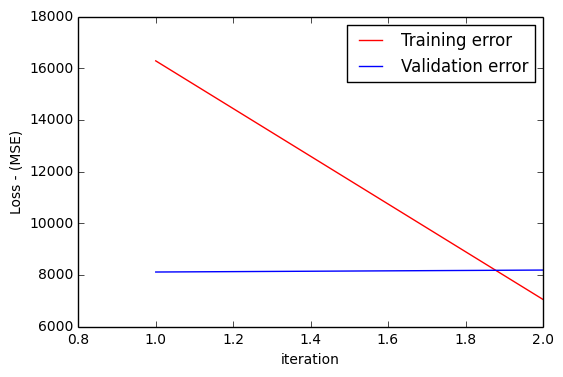

In [68]:
plt_losses(training_losses, validation_losses)

### Calculate the test error - random patches

In [ ]:
# Calculate the error between the predicted voxel values and target1 -- this is from registered scan 1 of the output

# First convert the testing targets to numpy arrays
testing_target1_nump = np.asarray(testing_target1)
testing_target2_nump = np.asarray(testing_target2)

# Get the predicted voxel values of the test set
test_predictions = get_predictions(trained_net, testloader)


In [132]:
get_errors(test_predictions, testing_target1_nump, testing_target2_nump, "patches")

-----------------------------

MSE on test patches: 8102.471191
Mean absolute loss on test patches: 59.307026
R2 loss on test patches (Coefficient of determination): 0.782132
Percentage of predictions within target range: 16.630152


In [139]:
get_errors_between_targets(testing_target1_nump, testing_target2_nump)

MSE between targets: 4285.291504
Mean absolute loss between targets: 37.079346
R2 loss between targets (Coefficient of determination): 0.884773


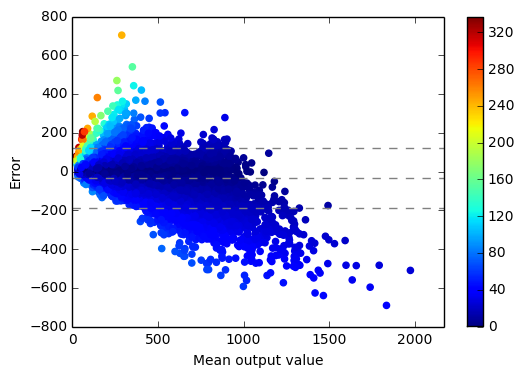

In [98]:
bland_altman_plot(test_predictions, testing_target1_nump, testing_target2_nump)

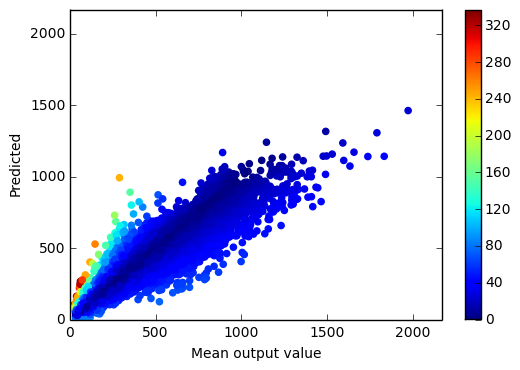

In [104]:
plot_predicted(test_predictions, testing_target1_nump, testing_target2_nump)

### Calculate error on the final testing scan

In [71]:
final_test_predictions = get_predictions(trained_net, final_test_loader)

0
250
500
750
1000
1250
1500


In [73]:
(x,y,z,v) = final_test_inp[0].shape
final_predicted_brain = reconstruct_brain(final_test_predictions,[x,y,z,v])
final_predicted_brain = replace_background(final_predicted_brain, final_test_inp[0])

In [74]:
print final_predicted_brain.shape
print final_test_out1[0].shape

(53, 72, 51, 1)
(53, 72, 51, 1)


## Calculate errors

In [134]:
get_errors(final_predicted_brain, final_test_out1[0], final_test_out2[0], "scan")

-----------------------------

MSE on test scan: 5037.836914
Mean absolute loss on test scan: 30.937536
R2 loss on test scan (Coefficient of determination): 0.881835
Percentage of predictions within target range: 60.007913


In [138]:
get_errors_between_targets(final_test_out1[0], final_test_out2[0])

MSE between targets: 737.694519
Mean absolute loss between targets: 11.102444
R2 loss between targets (Coefficient of determination): 0.982697


### Visualise predictions

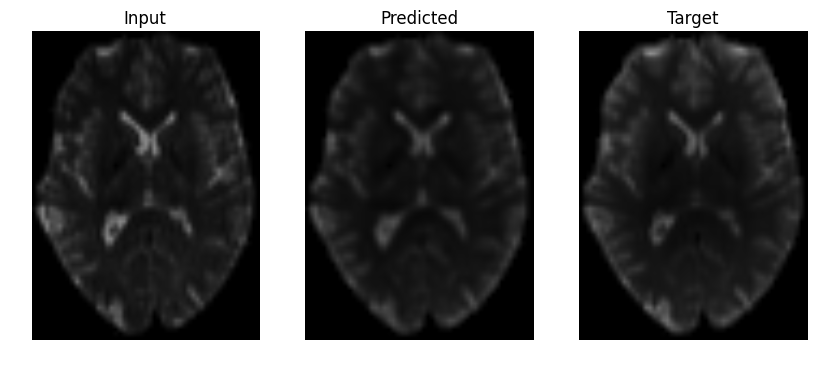

In [77]:
viz_pred(final_test_inp[0], final_predicted_brain, final_test_out1[0], 25)

## Save the target and the predicted scans

In [ ]:
save_to = "/Volumes/Seagate Backup Plus Drive/Project/Dataset/Experiments/Overfit/Subj1Scan1"

predicted_scan = nib.Nifti1Image(predicted_brain, affine_mat)
nib.save(predicted_scan, save_to + "/Predicted_scan.nii.gz" )

target_scan = nib.Nifti1Image(testing_data_out[0][:,:,:,0], affine_mat)
nib.save(target_scan, save_to + "/Target_scan.nii.gz" )

## Store the model parameters

In [ ]:
torch.save(trained_net.state_dict(), '/Volumes/Seagate Backup Plus Drive/Project/Dataset/Experiments/Overfit/Subj1Scan1/model.pth') 

## Load the model parameters

In [ ]:
trained_net = Net()
trained_net.load_state_dict(torch.load('/Volumes/Seagate Backup Plus Drive/Project/Dataset/Experiments/Overfit/Subj1Scan1/model.pth'))

In [ ]:
t = np.zeros([3,3,3])


In [123]:
x = np.array([1,2,3,4,5,6])
y = np.array([6,5,4,3,2,1])
ma = np.max([x,y], axis=0)
mi = np.min([x,y], axis=0)
a = np.array([1,1,4,4,1,1])

b = np.logical_and(a>=mi, a<=ma)
b = np.sum(b)
print b
print x.size
print float(b)/float(x.size)

4
6
0.666666666667
